In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
df_raw = data.copy()
df_raw.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
pip install texthero

     |████████████████████████████████| 235 kB 7.1 MB/s 
     |████████████████████████████████| 1.5 MB 42.8 MB/s 
     |████████████████████████████████| 749 kB 45.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import texthero as hero
custom_pipeline = [hero.preprocessing.fillna,
                   hero.preprocessing.lowercase,
                   hero.preprocessing.remove_whitespace,
                   hero.preprocessing.remove_urls,
                   hero.preprocessing.remove_digits,
                   hero.preprocessing.remove_punctuation,
                   hero.preprocessing.remove_diacritics
                   ]

df_raw['clean_posts_nn'] = df_raw['posts'].pipe(hero.clean, custom_pipeline)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_raw.head()

,type,posts,clean_posts_nn
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and intj moments sportscenter not top ten...
1,ENTP,'I'm finding the lack of me in these posts ver...,i m finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course to which i say i know t...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the oth...
4,ENTJ,'You're fired.|||That's another silly misconce...,you re fired that s another silly misconcepti...


In [ ]:
df_pro = df_raw.copy()

In [ ]:
df_pro = df_pro.drop(columns='posts')

In [ ]:
df_pro.head()

,type,clean_posts_nn
0,INFJ,and intj moments sportscenter not top ten...
1,ENTP,i m finding the lack of me in these posts ver...
2,INTP,good one course to which i say i know t...
3,INTJ,dear intp i enjoyed our conversation the oth...
4,ENTJ,you re fired that s another silly misconcepti...


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
X = df_pro['clean_posts_nn'] # features
y = df_pro['type']  # labels
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2)



In [ ]:
#Tag train set
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(X_train)]
#Tag test set
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(X_test)]

In [ ]:
model = Doc2Vec(vector_size=100,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8)
model.build_vocab(tagged_tr)

In [ ]:
epochs = range(50)
for epoch in epochs:
    print(f'Epoch {epoch+1}')
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.00025
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
     
model.save('math_lectures.model')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


In [ ]:
X_train_1 = np.array([model.docvecs[str(i)] for i in range(len(tagged_tr))])


In [ ]:
X_test_1 = np.array([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

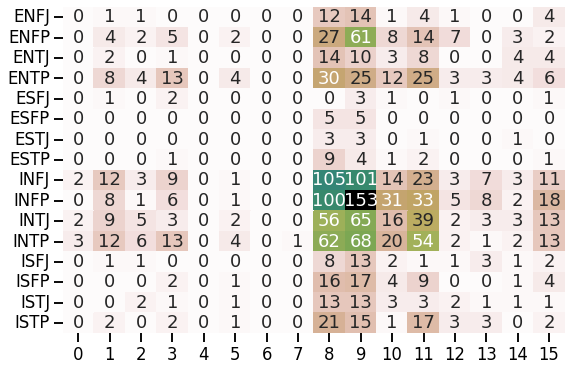

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.07      0.03      0.04       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.22      0.09      0.13       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.22      0.36      0.27       294
        INFP       0.27      0.42      0.33       366
        INTJ       0.14      0.07      0.10       218
        INTP       0.23      0.21      0.22       261
        ISFJ       0.03      0.03      0.03        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.04      0.02      0.03        41
        ISTP       0.02      0.03      0.03        67

    accuracy                           0.20      1735
   macro avg       0.08   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_decision_doc2vec = DecisionTreeClassifier()
# Fit the model
clf_decision_doc2vec.fit(X_train_1,y_train)
y_pred = clf_decision_doc2vec.predict(X_test_1)
heatconmat(y_test,y_pred)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


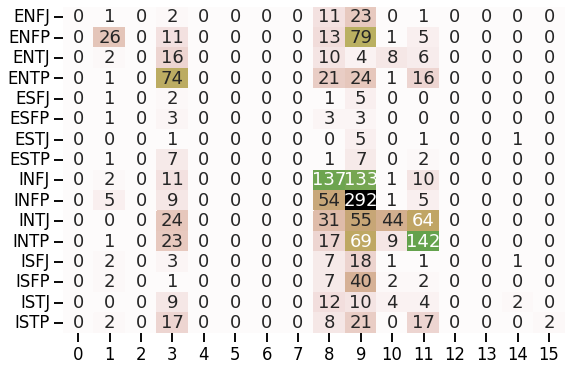

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.55      0.19      0.29       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.35      0.54      0.42       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.41      0.47      0.44       294
        INFP       0.37      0.80      0.51       366
        INTJ       0.61      0.20      0.30       218
        INTP       0.51      0.54      0.53       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.50      0.05      0.09        41
        ISTP       1.00      0.03      0.06        67

    accuracy                           0.41      1735
   macro avg       0.27   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import LogisticRegression


lrc = LogisticRegression(C=5, multi_class='multinomial', solver='saga',max_iter=1000)
lrc.fit(X_train_1,y_train)
y_pred = lrc.predict(X_test_1)
heatconmat(y_test,y_pred)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

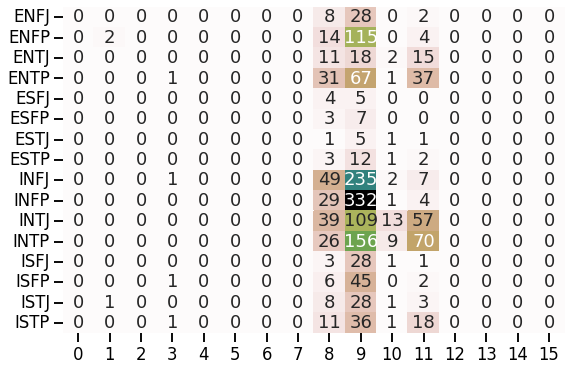

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.67      0.01      0.03       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.25      0.01      0.01       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.20      0.17      0.18       294
        INFP       0.27      0.91      0.42       366
        INTJ       0.39      0.06      0.10       218
        INTP       0.31      0.27      0.29       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

    accuracy                           0.27      1735
   macro avg       0.13   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_1,y_train)
y_pred = rf.predict(X_test_1)
heatconmat(y_test,y_pred)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

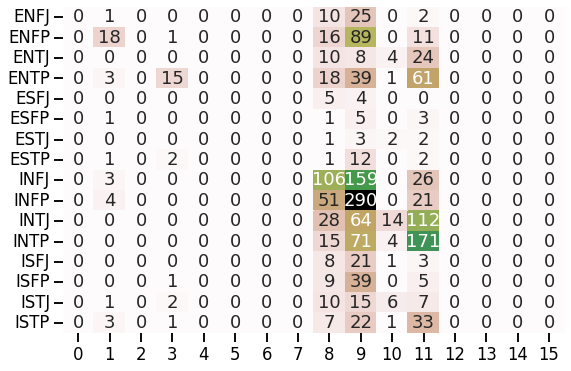

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.51      0.13      0.21       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.68      0.11      0.19       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.36      0.36      0.36       294
        INFP       0.33      0.79      0.47       366
        INTJ       0.42      0.06      0.11       218
        INTP       0.35      0.66      0.46       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

    accuracy                           0.35      1735
   macro avg       0.17   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train_1,y_train)
y_pred = lgb.predict(X_test_1)
heatconmat(y_test,y_pred)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


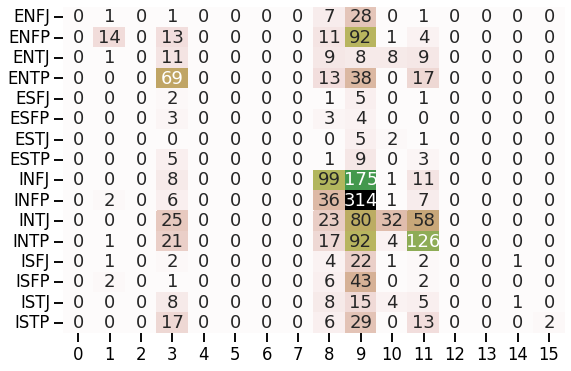

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.64      0.10      0.18       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.36      0.50      0.42       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.41      0.34      0.37       294
        INFP       0.33      0.86      0.47       366
        INTJ       0.59      0.15      0.24       218
        INTP       0.48      0.48      0.48       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.50      0.02      0.05        41
        ISTP       1.00      0.03      0.06        67

    accuracy                           0.38      1735
   macro avg       0.27   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train_1,y_train)
y_pred = clf.predict(X_test_1)
heatconmat(y_test,y_pred)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

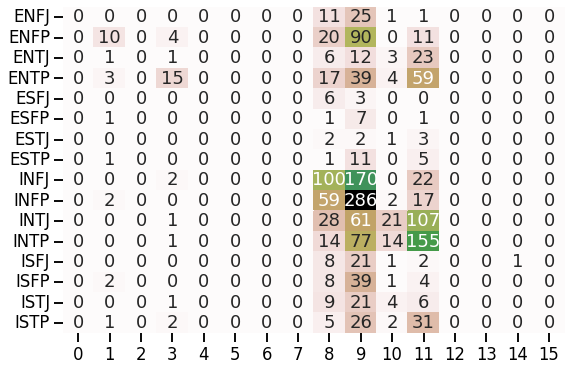

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.48      0.07      0.13       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.56      0.11      0.18       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.34      0.34      0.34       294
        INFP       0.32      0.78      0.46       366
        INTJ       0.39      0.10      0.15       218
        INTP       0.35      0.59      0.44       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

    accuracy                           0.34      1735
   macro avg       0.15   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_1,y_train)
y_pred = xgb.predict(X_test_1)
heatconmat(y_test,y_pred)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

## Count Vector

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    stemmer = PorterStemmer()
    cachedStopWords = stopwords.words("english")
    cleaned_text=[]
    for sentence in data.clean_posts_nn:
        sentence=sentence.lower()
        
# #         removing links from text data
#         sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
# #         removing other symbols Keep only words
#         sentence=re.sub('[^0-9a-z]',' ',sentence)
# #          remove spaces > 1
#         sentence = re.sub(' +', ' ', sentence)
#          Remove stopwords and lematize
        sentence = " ".join([lemmatizer.lemmatize(w) for w in sentence.split(' ') if w not in cachedStopWords])
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [ ]:
df_pro

,type,clean_posts_nn
0,intp,i don t care about fitting in i don t want to...
1,intp,i m sorry i can t understand what you re tryi...
2,intp,my quandary is that that isn t an attitude s...
3,intp,i really couldn t care less about them but i l...
4,intp,if one of my very very close friends is sad or...
...,...,...
18586,estp,definitely more ti
18587,estp,oh shit
18588,isfj,keep it up i also learned how to crochet last...
18589,isfp,shout out to u rapproducer being of the sub


In [ ]:
df_lem = df_pro.copy()

In [ ]:
df_lem.clean_posts_nn,train_length=clear_text(df_lem)
df_lem.head()

,type,clean_posts_nn
0,intp,care fitting want average need better averag...
1,intp,sorry understand trying say
2,intp,quandary attitude much simple fact calling ...
3,intp,really care le love actually going college foo...
4,intp,one close friend sad distraught understand bit...


In [ ]:
from sklearn.model_selection import train_test_split
X = df_lem['clean_posts_nn'] # features
y = df_lem['type']  # labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(X_train)
    
# clf = LinearSVC()
# clf.fit(X_train_tfidf, y_train)
    
# Pipelining the vectorizer and the classifier
text_lr = Pipeline([('countvec',CountVectorizer()),('lr',LogisticRegression())])
text_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('countvec', CountVectorizer()), ('lr', LogisticRegression())])

In [ ]:
lr_predictions = text_lr.predict(X_test)

print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

        enfj       0.29      0.31      0.30       300
        enfp       0.19      0.20      0.20       300
        entj       0.25      0.24      0.24       300
        entp       0.16      0.18      0.17       300
        esfj       0.75      0.38      0.50         8
        esfp       0.27      0.15      0.20        71
        estj       0.60      0.38      0.46         8
        estp       0.35      0.26      0.30       183
        infj       0.18      0.17      0.18       300
        infp       0.17      0.16      0.17       300
        intj       0.12      0.13      0.12       300
        intp       0.16      0.22      0.19       300
        isfj       0.40      0.36      0.38       295
        isfp       0.53      0.37      0.44       154
        istj       0.32      0.29      0.30       300
        istp       0.21      0.24      0.22       300

    accuracy                           0.23      3719
   macro avg       0.31   

In [ ]:
print('Testing accuracy %s' % accuracy_score(y_test, lr_predictions))
print('Testing F1 score: {}'.format(f1_score(y_test, lr_predictions, average='weighted')))

Testing accuracy 0.2342027426727615
Testing F1 score: 0.23770642080374604


## word cloud

In [ ]:
pip install wordcloud

In [ ]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

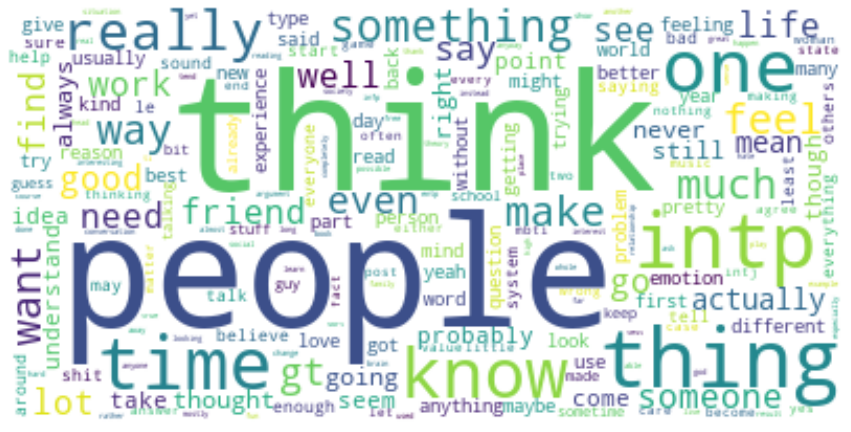

In [ ]:
text = " ".join(i for i in df_lem[df_lem['type']=='intp'].clean_posts_nn)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

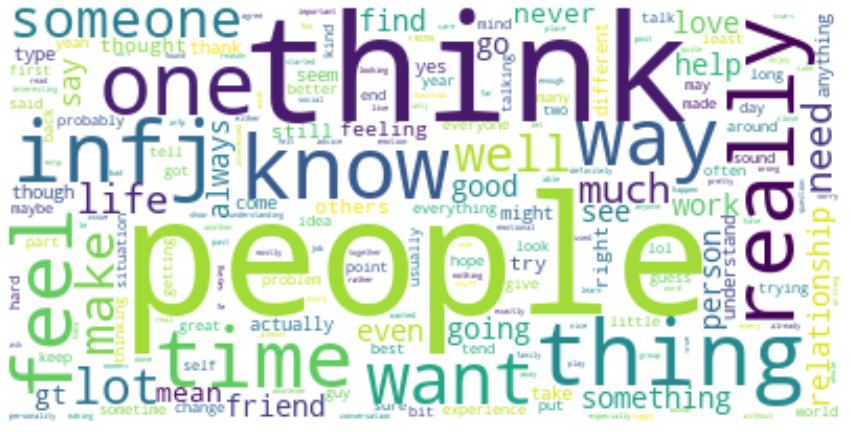

In [ ]:
text = " ".join(i for i in df_lem[df_lem['type']=='infj'].clean_posts_nn)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## sentiment analysis

In [ ]:
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')
sia = vd.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df_lem = df_lem.drop(columns=['sentiment_score','sentiment'])

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
SIA = SentimentIntensityAnalyzer()
df_lem['polarity_score']=df_lem.clean_posts_nn.apply(lambda 
x:SIA.polarity_scores(x)['compound'])
df_lem['neutral_score']=df_lem.clean_posts_nn.apply(lambda x:SIA.polarity_scores(x)['neu'])
df_lem['negative_score']=df_lem.clean_posts_nn.apply(lambda x:SIA.polarity_scores(x)['neg'])
df_lem['positive_score']=df_lem.clean_posts_nn.apply(lambda x:SIA.polarity_scores(x)['pos'])
df_lem['sentiment']=''
df_lem.loc[df_lem.polarity_score>0,'sentiment']='POSITIVE'
df_lem.loc[df_lem.polarity_score==0,'sentiment']='NEUTRAL'
df_lem.loc[df_lem.polarity_score<0,'sentiment']='NEGATIVE'
df_lem.head()

,type,clean_posts_nn,polarity_score,neutral_score,negative_score,positive_score,sentiment
0,intp,care fitting want average need better averag...,0.4404,0.355,0.207,0.438,POSITIVE
1,intp,sorry understand trying say,-0.0772,0.698,0.302,0.000,NEGATIVE
2,intp,quandary attitude much simple fact calling ...,-0.2732,0.830,0.107,0.063,NEGATIVE
3,intp,really care le love actually going college foo...,0.9195,0.457,0.000,0.543,POSITIVE
4,intp,one close friend sad distraught understand bit...,0.6453,0.351,0.302,0.346,POSITIVE


In [ ]:
df_lem.groupby(by=['type'])['polarity_score'].mean()

type
enfj    0.467061
enfp    0.378179
entj    0.319228
entp    0.276727
esfj    0.996014
esfp    0.455216
estj    0.850354
estp    0.321096
infj    0.417045
infp    0.385404
intj    0.310851
intp    0.238082
isfj    0.506143
isfp    0.594544
istj    0.393206
istp    0.281073
Name: polarity_score, dtype: float64

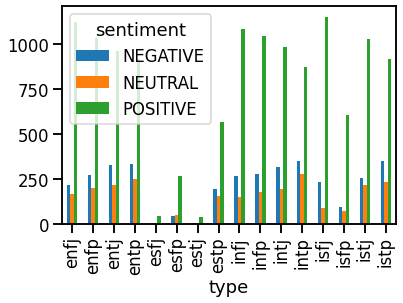

In [ ]:
df2=df_lem.groupby(['type', 'sentiment']).size()
df2=df2.unstack()
df2.plot(kind='bar')